On 2018, Kaggle launched a competition in association with Jigsaw/Conversation AI to classify toxic comments. The original competition can be viewed [here](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge). A toxic comment is a comment that is rude, disrespectful or otherwise likely to make someone leave a discussion. The goal of this competition was to build a multi-headed model that’s capable of detecting different types of of toxicity like threats, obscenity, insults, and identity-based hate.

However, the models developed in this competition unfortunately associated the targetted group with toxicity, i.e. "gay". For example, a comment like "I am a gay woman" would be classified as toxic. This happened as the examples of identities associated with toxicity outnumbered neutral comments regarding the same identity.

Therefore, the same team launched a new competition to recognize unintended bias towards identities. We are asked to use a dataset labeled with the associated identity. Let's look into the dataset and understand it first, so we can create a model that can better deal with bias.

This notebook is heavily based on the kernel:
https://www.kaggle.com/nz0722/simple-eda-text-preprocessing-jigsaw. The purpose of this Kernel is to walk Kaggle newbies through the process of data exploration and visualization. In this notebook, we will use Pandas to do a little bit of data wrangling and Plotly and Seaborn to visualize the result of our wrangling. 

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
print(os.listdir("../input"))

['test.csv', 'train.csv', 'sample_submission.csv']


In [11]:
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')

## Section 1: Understanding The Shape of Data

In [12]:
# First, lets count how much data we have!
train_len, test_len = len(train_df.index), len(test_df.index)
print(f'train size: {train_len}, test size: {test_len}')

train size: 1804874, test size: 97320


If you want to understand each of the field, it is a good idea to read the data section of the Kaggle competition (https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/data). Let's take a couple of minutes to read this section first.

In [13]:
# also, lets take a quick look at what we have 
train_df.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:41.987077+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:42.870083+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:45.222647+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:47.601894+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-09-29 10:50:48.488476+00,2,NaN,2006,rejected,0,0,0,1,0,0.0,4,47


In [14]:
# its always a good idea to count the amount of missing values before diving into any analysis
# Lets also see how many missing values (in percentage) we are dealing with
miss_val_train_df = train_df.isnull().sum(axis=0) / train_len
miss_val_train_df = miss_val_train_df[miss_val_train_df > 0] * 100
miss_val_train_df

asian                                  77.553558
atheist                                77.553558
bisexual                               77.553558
black                                  77.553558
buddhist                               77.553558
christian                              77.553558
female                                 77.553558
heterosexual                           77.553558
hindu                                  77.553558
homosexual_gay_or_lesbian              77.553558
intellectual_or_learning_disability    77.553558
jewish                                 77.553558
latino                                 77.553558
male                                   77.553558
muslim                                 77.553558
other_disability                       77.553558
other_gender                           77.553558
other_race_or_ethnicity                77.553558
other_religion                         77.553558
other_sexual_orientation               77.553558
physical_disability 

> As you can see from the table above, a large portion of the data is missing the identity tag. However, as the number is the same for the tags, I assume that the data is complete for the part which has identity tags.

## Section 2: Identity Analysis and Barplots

Now that we know a large portion of our dataset is doesn't have the group identity, (for now) we can drop it before we do any basic analysis. First simple and interesting question to answer would be which identity appears the most in the dataset. 

In [15]:
# lets create a list of all the identities tagged in this dataset. This list given in the data section of this competition. 
identities = ['male','female','transgender','other_gender','heterosexual','homosexual_gay_or_lesbian',
              'bisexual','other_sexual_orientation','christian','jewish','muslim','hindu','buddhist',
              'atheist','other_religion','black','white','asian','latino','other_race_or_ethnicity',
              'physical_disability','intellectual_or_learning_disability','psychiatric_or_mental_illness',
              'other_disability']

In [16]:
# getting the dataframe with identities tagged
train_labeled_df = train_df.loc[:, ['target'] + identities ].dropna()
# lets define toxicity as a comment with a score being equal or .5
# in that case we divide it into two dataframe so we can count toxic vs non toxic comment per identity
toxic_df = train_labeled_df[train_labeled_df['target'] >= .5][identities]
non_toxic_df = train_labeled_df[train_labeled_df['target'] < .5][identities]

In [17]:
# at first, we just want to consider the identity tags in binary format. So if the tag is any value other than 0 we consider it as 1.
toxic_count = toxic_df.where(train_labeled_df == 0, other = 1).sum()
non_toxic_count = non_toxic_df.where(train_labeled_df == 0, other = 1).sum()

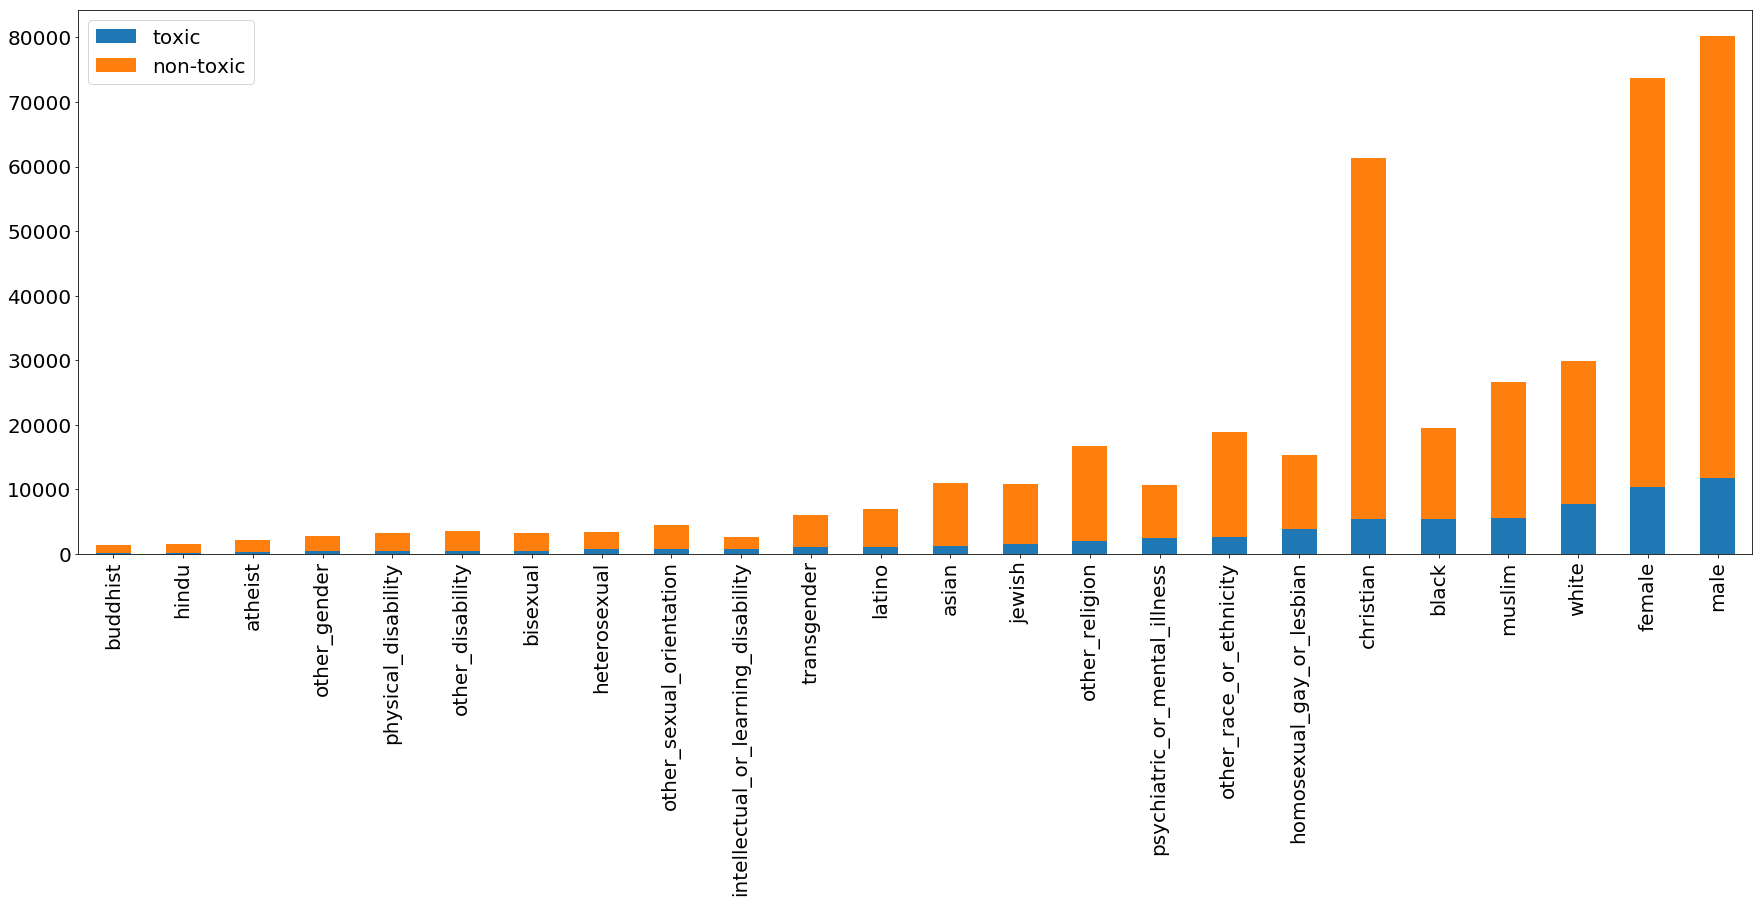

In [18]:
# now we can concat the two series together to get a toxic count vs non toxic count for each identity
toxic_vs_non_toxic = pd.concat([toxic_count, non_toxic_count], axis=1)
toxic_vs_non_toxic = toxic_vs_non_toxic.rename(index=str, columns={1: "non-toxic", 0: "toxic"})
# here we plot the stacked graph but we sort it by toxic comments to (perhaps) see something interesting
toxic_vs_non_toxic.sort_values(by='toxic').plot(kind='bar', stacked=True, figsize=(30,10), fontsize=20).legend(prop={'size': 20})

The diagram above is certainly one way of looking at our data. However, it is missing the complete picture because we are not using two things. First, for each example we have a score (target) of how toxic the comment is. Second, each identity also has a value between 0 to 1 to identify how much they have been targeted. We can use this two aspects to our advantage and see which identities are more frequently related to toxic comments.

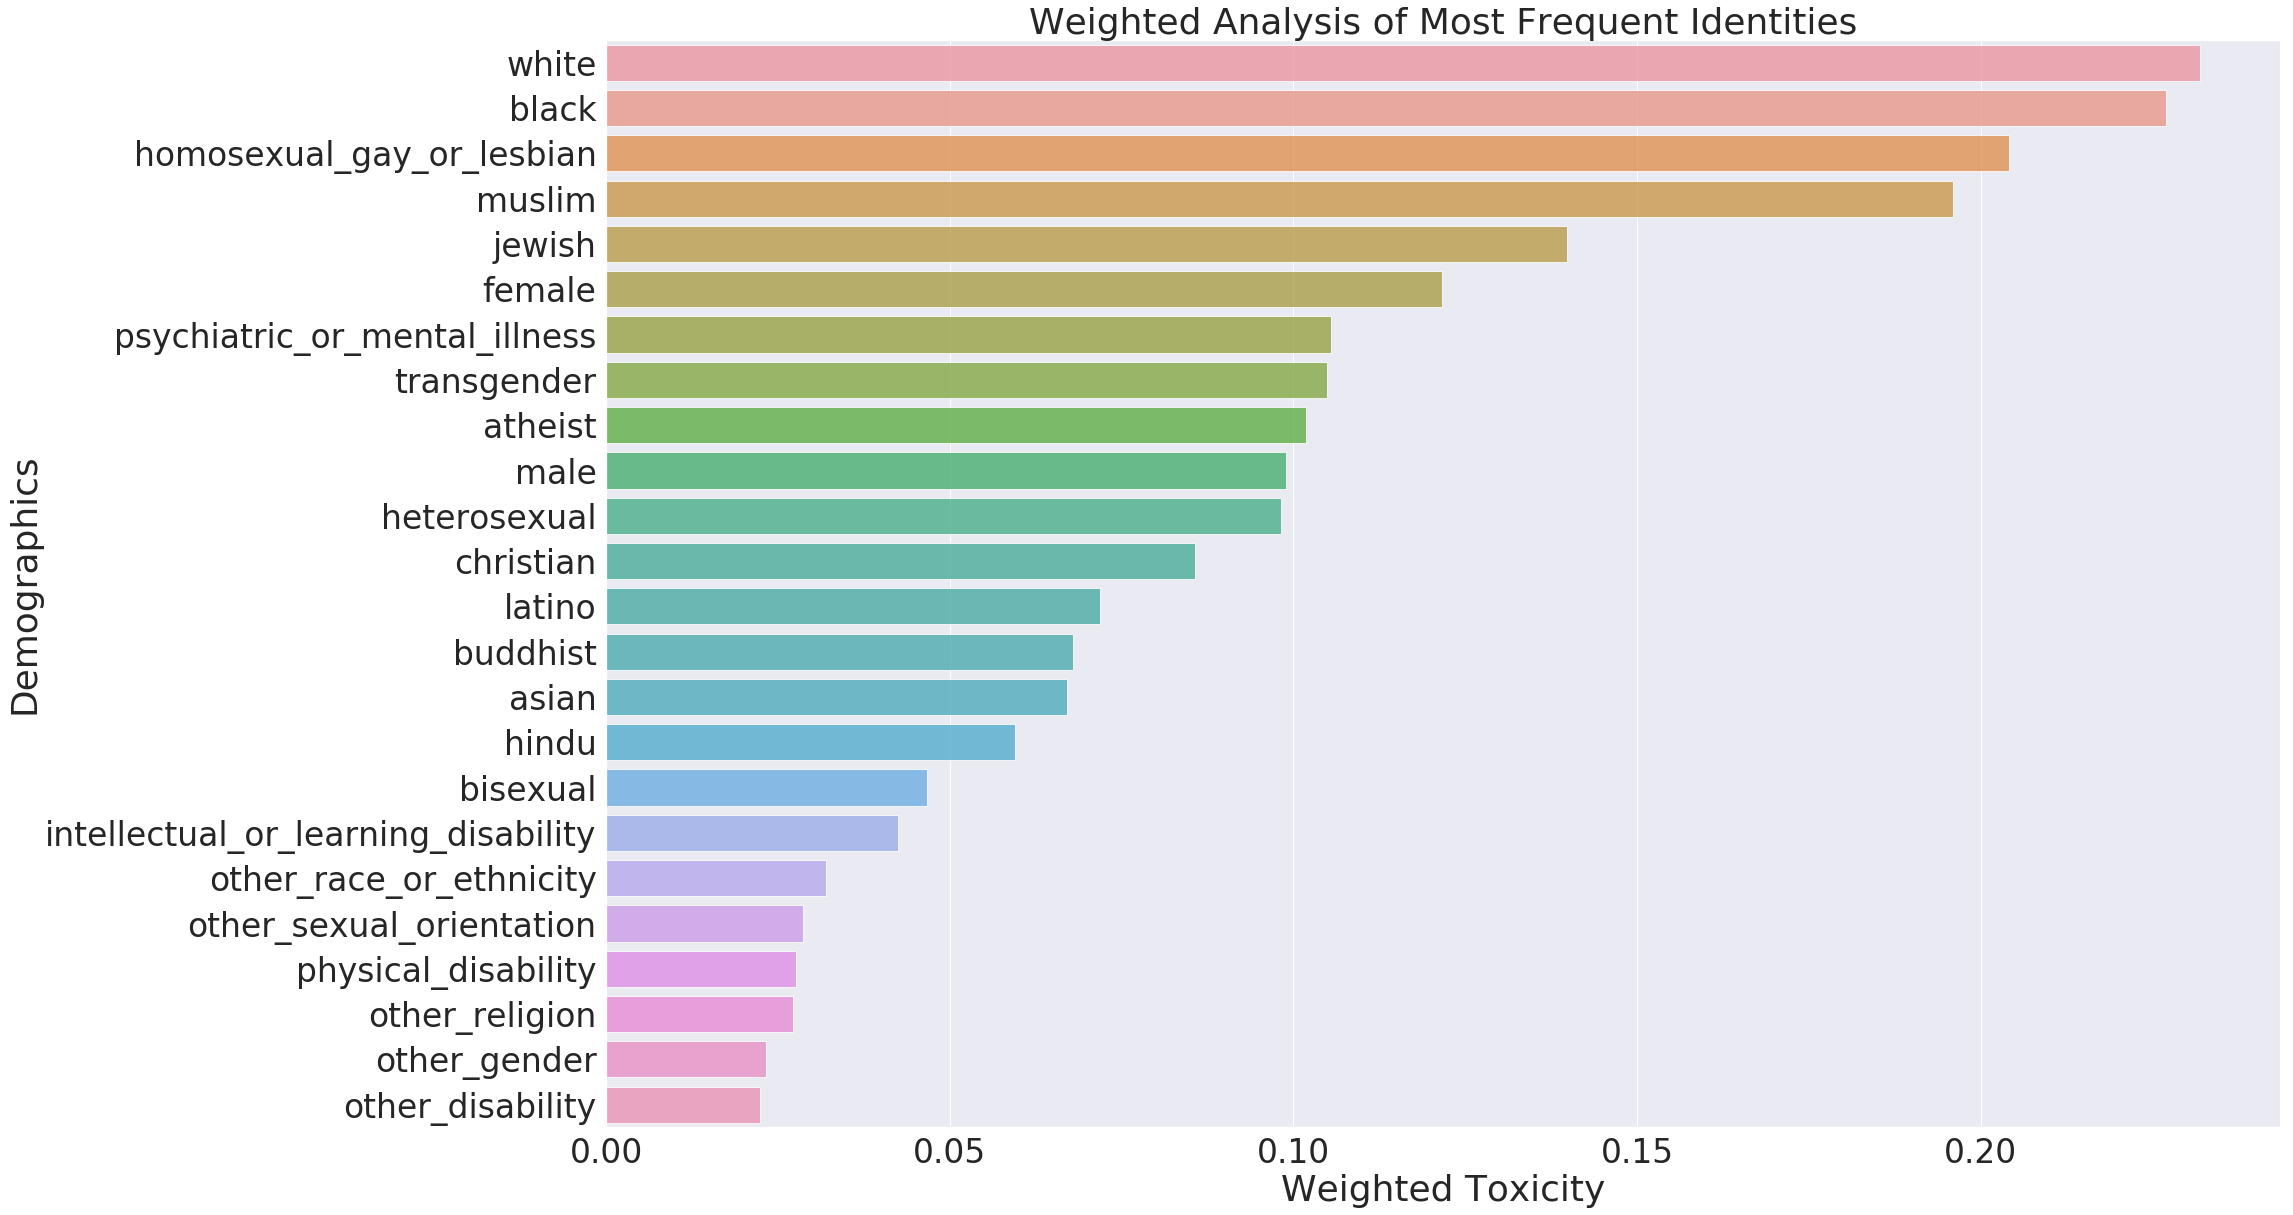

In [20]:
# First we multiply each identity with the target
weighted_toxic = train_labeled_df.iloc[:, 1:].multiply(train_labeled_df.iloc[:, 0], axis="index").sum() 
# changing the value of identity to 1 or 0 only and get comment count per identity group
identity_label_count = train_labeled_df[identities].where(train_labeled_df == 0, other = 1).sum()
# then we divide the target weighted value by the number of time each identity appears
weighted_toxic = weighted_toxic / identity_label_count
weighted_toxic = weighted_toxic.sort_values(ascending=False)
# plot the data using seaborn like before
plt.figure(figsize=(30,20))
sns.set(font_scale=3)
ax = sns.barplot(x = weighted_toxic.values , y = weighted_toxic.index, alpha=0.8)
plt.ylabel('Demographics')
plt.xlabel('Weighted Toxicity')
plt.title('Weighted Analysis of Most Frequent Identities')
plt.show()

As we can see from the graph above, the two race based identities (White and Black) and religion based identities (Muslim and Jews) are heavily associated with toxic comments. 

## Section 3: Data Wrangling and Correlation Plotting with Heatmap

We can also do a little data wrangling to create our own features and see how they correlate to different labels within our data.

In [ ]:
# total length of characters in the comment
train_df['total_length'] = train_df['comment_text'].apply(len)

In [ ]:
# number of capital letters
train_df['capitals'] = train_df['comment_text'].apply(lambda comment: sum(1 for c in comment if c.isupper()))

In [ ]:
# ratio of capital characters vs length of the comment
train_df['caps_vs_length'] = train_df.apply(lambda row: float(row['capitals'])/float(row['total_length']),axis=1)

In [ ]:
# count of special characters
train_df['num_exclamation_marks'] = train_df['comment_text'].apply(lambda comment: comment.count('!'))
train_df['num_question_marks'] = train_df['comment_text'].apply(lambda comment: comment.count('?'))
train_df['num_punctuation'] = train_df['comment_text'].apply(lambda comment: sum(comment.count(w) for w in '.,;:'))
train_df['num_symbols'] = train_df['comment_text'].apply(lambda comment: sum(comment.count(w) for w in '*&$%'))

In [ ]:
# word count
train_df['num_words'] = train_df['comment_text'].apply(lambda comment: len(comment.split()))

In [ ]:
# number of unique words in the comment
train_df['num_unique_words'] = train_df['comment_text'].apply(lambda comment: len(set(w for w in comment.split())))

In [ ]:
# ratio of unique words and number of words
train_df['words_vs_unique'] = train_df['num_unique_words'] / train_df['num_words']

In [ ]:
# number of smiley faces
train_df['num_smilies'] = train_df['comment_text'].apply(lambda comment: sum(comment.count(w) for w in (':-)', ':)', ';-)', ';)')))

In [ ]:
# let's create a list of columns with the new features we have just created
new_features = ['total_length', 'capitals', 'caps_vs_length', 'num_exclamation_marks','num_question_marks', 
            'num_punctuation', 'num_words', 'num_unique_words','words_vs_unique', 'num_smilies', 'num_symbols']
# the dataset is labeled with more information alongside the target. lets collect them in a list as well
labels = ['target', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat', 'funny', 'wow', 'sad', 
           'likes', 'disagree', 'sexual_explicit','identity_annotator_count', 'toxicity_annotator_count']

In [ ]:
# lets loop over each feature and calculate its correlation with a label
rows = [{label:train_df[feature].corr(train_df[label]) for label in labels} 
        for feature in new_features]
train_correlations = pd.DataFrame(rows, index=new_features)

In [ ]:
# now we have our beautiful correlation matrix
train_correlations

In [ ]:
# heatmaps are great for visualizing correlation matrix. and its very simple to do so in seaborn
plt.figure(figsize=(10, 6))
sns.set(font_scale=1)
ax = sns.heatmap(train_correlations, vmin=-0.1, vmax=0.1, center=0.0)

We can certainly see some interesting patterns. For example, funny comments seems to have negative correlation with the size of the comment and also the number of capital characters in the comments.

## Section 4: Time series analysis with Plotly
**
The dataset also has a 'created_date' field, which tells us when the comment was made. We can use this field to do some time series analysis. In this section, we will also use plotly for simplifying our visualization needs.**

In [ ]:
# lets take the dataset with identitiy tags, created date, and target column
with_date_df = train_df.loc[:, ['created_date', 'target'] + identities].dropna()
# next we will create a weighted dataframe for each identity tag (like we did before)
# first we divide each identity tag with the total value it has in the dataset
weighted_df = with_date_df.iloc[:, 2:] / with_date_df.iloc[:, 2:].sum()
# then we multiplty this value with the target 
target_weighted_df = weighted_df.multiply(with_date_df.iloc[:, 1], axis="index")
# lets add a column to count the number of comments
target_weighted_df['comment_count'] = 1
# now we add the date to our newly created dataframe (also parse the text date as datetime)
target_weighted_df['created_date'] = pd.to_datetime(with_date_df['created_date']).values.astype('datetime64[M]')
# now we can do a group by of the created date to count the number of times a identity appears for that date
identity_weight_per_date_df = target_weighted_df.groupby(['created_date']).sum().sort_index()

In [ ]:
races = ['black','white','asian','latino','other_race_or_ethnicity']
identity_weight_per_date_df[races].plot(figsize=(20,10), linewidth=1, fontsize=20)

In [ ]:
religions = ['atheist', 'buddhist', 'christian', 'hindu', 'muslim', 'other_religion']
identity_weight_per_date_df[religions].plot(figsize=(20,10), linewidth=1, fontsize=20)

In [ ]:
sexual_orientation = ['heterosexual', 'homosexual_gay_or_lesbian', 'bisexual', 'other_sexual_orientation']
identity_weight_per_date_df[sexual_orientation].plot(figsize=(20,10), linewidth=1, fontsize=20)

In [ ]:
# however we can also see that the total number of comments are increasing as the day goes by. perhaps we should take a relative percentage for the graphs above.
identity_weight_per_date_df['comment_count'].plot(figsize=(20,10), linewidth=1, fontsize=20)